## Download tumor purity data

The TCGA PanCanAtlas used [ABSOLUTE](https://doi.org/10.1038/nbt.2203) to calculate tumor purity and cell ploidy for samples with WES data. We'll use tumor purity values as a target variable/label for some of our multi-omics experiments.

In [1]:
import os
from urllib.request import urlretrieve

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du

In [2]:
# from manifest:
# https://gdc.cancer.gov/files/public/file/PanCan-General_Open_GDC-Manifest_2.txt
# (retrieved on August 1, 2022)
purity_id = '4f277128-f793-4354-a13d-30cc7fe9f6b5'
purity_filename = 'TCGA_mastercalls.abs_tables_JSedit.fixed.txt'
purity_md5 = '8ea2ca92c8ae58350538999dfa1174da'

In [3]:
purity_filepath = os.path.join(cfg.data_dir, purity_filename)
if not os.path.exists(cfg.data_dir):
    os.makedirs(cfg.data_dir)

In [4]:
url = 'http://api.gdc.cancer.gov/data/{}'.format(purity_id)
    
if not os.path.exists(purity_filepath):
    urlretrieve(url, purity_filepath)
else:
    print('Downloaded data file already exists, skipping download')

Downloaded data file already exists, skipping download


In [5]:
md5_sum = !md5sum $purity_filepath
print(md5_sum[0])
assert md5_sum[0].split(' ')[0] == purity_md5

8ea2ca92c8ae58350538999dfa1174da  /home/jake/research/pancancer-evaluation/data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt


### Read and explore purity labels

In particular, we want to see which cancer types have purity labels, and how many samples exist for each cancer type.

In [6]:
purity_df = pd.read_csv(purity_filepath, sep='\t')

print(purity_df.shape)
purity_df.head()

(10786, 10)


,array,sample,call status,purity,ploidy,Genome doublings,Coverage for 80% power,Cancer DNA fraction,Subclonal genome fraction,solution
0,TCGA-OR-A5J1-01,TCGA-OR-A5J1-01A-11D-A29H-01,called,0.90,2.00,0.0,9.0,0.90,0.02,new
1,TCGA-OR-A5J2-01,TCGA-OR-A5J2-01A-11D-A29H-01,called,0.89,1.30,0.0,6.0,0.84,0.16,new
2,TCGA-OR-A5J3-01,TCGA-OR-A5J3-01A-11D-A29H-01,called,0.93,1.27,0.0,5.0,0.89,0.11,new
3,TCGA-OR-A5J4-01,TCGA-OR-A5J4-01A-11D-A29H-01,called,0.87,2.60,1.0,12.0,0.89,0.08,new
4,TCGA-OR-A5J5-01,TCGA-OR-A5J5-01A-11D-A29H-01,called,0.93,2.79,1.0,12.0,0.95,0.15,new


In [7]:
assert purity_df['array'].duplicated().sum() == 0

purity_df = (purity_df
  .set_index('array')
  .loc[:, ['purity']]
)
    
purity_df.head()

,purity
array,
TCGA-OR-A5J1-01,0.90
TCGA-OR-A5J2-01,0.89
TCGA-OR-A5J3-01,0.93
TCGA-OR-A5J4-01,0.87
TCGA-OR-A5J5-01,0.93


In [8]:
# load cancer type labels
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

sample_freeze_df.head()

Loading pan-cancer data from cached pickle file...


,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


In [9]:
# join cancer type and purity info
purity_cancer_type_df = (purity_df
  .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
  .drop(columns=['PATIENT_BARCODE'])
  .dropna(subset=['purity'])
)

print(purity_cancer_type_df.shape)
purity_cancer_type_df.head()

(8872, 4)


,purity,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,0.90,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,0.89,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,0.93,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,0.93,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,0.69,TCGA-OR-A5J6-01,ACC,Not_Applicable


Text(0.5, 1.0, 'Distribution of samples with tumor purity measured')

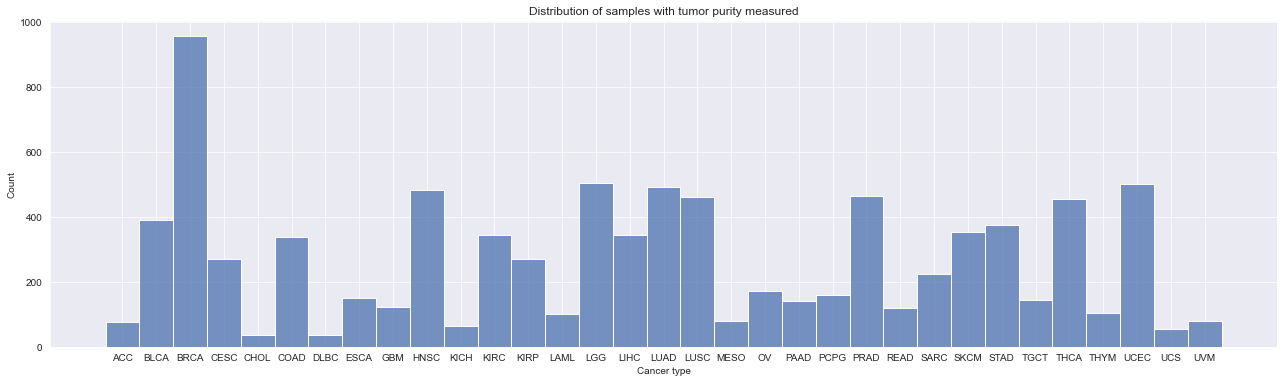

In [10]:
sns.set({'figure.figsize': (22, 6)})

sns.histplot(purity_cancer_type_df, x='DISEASE', discrete=True)
plt.xlabel('Cancer type')
plt.title('Distribution of samples with tumor purity measured')

Text(0.5, 1.0, 'Tumor purity distribution, per cancer type')

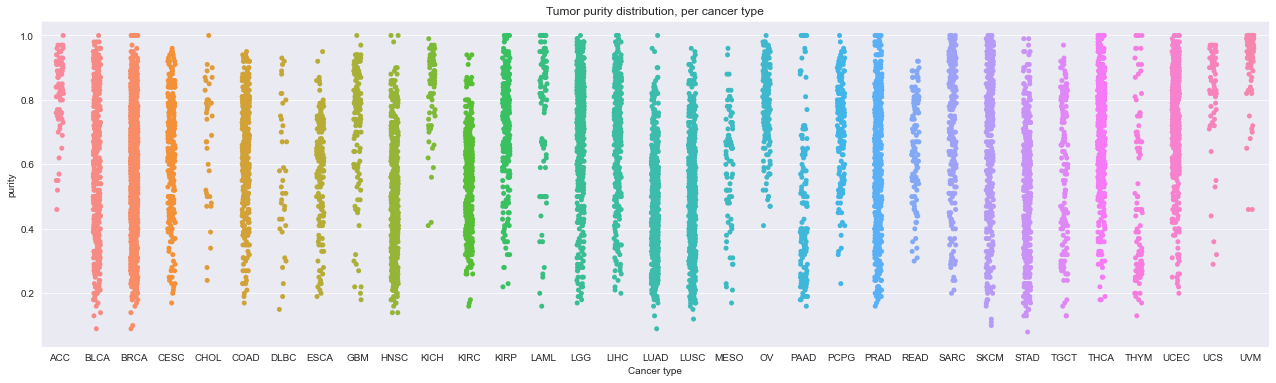

In [11]:
sns.set({'figure.figsize': (22, 6)})

sns.stripplot(data=purity_cancer_type_df, x='DISEASE', y='purity')
plt.xlabel('Cancer type')
plt.title('Tumor purity distribution, per cancer type')

In [12]:
purity_cancer_type_df.purity.isna().sum()

0